## Protein Embeddings Manipulation

In [1]:
from pathlib import Path

data_path = Path("data") 

!ls $data_path

embeddings_fireprot.pkl  fireprotdb_results.csv  stability_fireprot.h5


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

from protera_stability.data import ProteinStabilityDataset

### Get Dataset

In [4]:
train_set = ProteinStabilityDataset(proteins_path=data_path / "stability_fireprot.h5")
# test_set =  ProteinStabilityDataset(proteins_path=data_path / "stability_test.h5")
len(train_set)

4950

In [5]:
train_set.X.mean(), train_set.X.var(), train_set.X.shape

(9.166472e-11, 1.0000002, (4950, 1280))

In [6]:
train_set.y.mean(), train_set.y.var(), train_set.y.shape

(9.247751e-09, 1.0, (4950,))

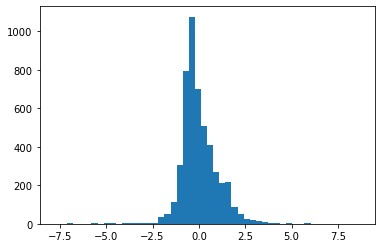

In [7]:
plt.hist(train_set.y, bins=50)
plt.show()

## Can a FeedForward Net do better?


In [58]:
from torch import nn
import torch

class ProteinMLP(nn.Module):
    def __init__(self, n_in = 1280, n_units = 512, act = None, drop_p = 0.65, last_drop = True):
        super(ProteinMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_units)
        self.fc2 = nn.Linear(n_units, n_units)
        self.fc3 = nn.Linear(n_units, 1)
        
        self.drop = nn.Dropout(p=drop_p)

        self.last_drop = last_drop
        self.act = act
        if act is None:
            self.act = nn.GELU()
            
    def forward(self, x):
        out = self.drop(self.act(self.fc1(x)))
        out = self.drop(self.act(self.fc2(out)))
        
        if self.last_drop: 
            out = self.drop(out)
        return self.fc3(out)

In [59]:
from skorch.callbacks import Checkpoint, LRScheduler, EarlyStopping
from skorch import NeuralNetRegressor

cb = Checkpoint(dirname='models')
sched = LRScheduler(step_every="batch")
stopper = EarlyStopping(patience=15)

net = NeuralNetRegressor(
    ProteinMLP,
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    # optimizer__momentum=0.05,
    optimizer__weight_decay=1e-2,
    max_epochs=int(1e4),
    lr=1e-3,
    iterator_train__shuffle=True,
    device='cuda:1',
    callbacks=[cb, sched, stopper],
)

net.fit(train_set.X, train_set.y.reshape(-1,1))

# net.score(test_set.X, test_set.y)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1     8950.4904       12.4997     +  0.1571
      2       49.8048        0.6648     +  0.1168
      3       11.2640        0.6650        0.1073
      4        4.7616        0.6651        0.1002
      5        4.4832        0.6651        0.1087
      6        2.9776        0.6652        0.1136
      7        4.8154        0.6658        0.1155
      8        2.1566        0.6659        0.1158
      9        2.0373        0.6660        0.1178
     10        1.5341        0.6660        0.1186
     11        1.6100        0.6666        0.1159
     12        2.2609        0.6672        0.1237
     13        1.7207        0.6678        0.1197
     14        2.1613        0.6680        0.1167
     15        1.5881        0.6686        0.1181
     16        1.9396        0.6687        0.1195
Stopping since valid_loss has not improved in the last 15 epochs.


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=ProteinMLP(
    (fc1): Linear(in_features=1280, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=1, bias=True)
    (drop): Dropout(p=0.65, inplace=False)
    (act): GELU()
  ),
)

In [60]:
net.score(train_set.X, train_set.y)

-0.0002756875646132695